# PMEmo Dataset - Feed Forward Neural Network
## Essentia Best Overall openSMILE eGeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_pmemo_path('processed/annotations/pmemo_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,1,0.150,-0.200
1,4,-0.425,-0.475
2,5,-0.600,-0.700
3,6,-0.300,0.025
4,7,0.450,0.400
...,...,...,...
762,993,0.525,0.725
763,996,0.125,0.750
764,997,0.325,0.425
765,999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_egemaps = pd.read_csv(get_pmemo_path('processed/features/integrated/normalised_essentia_best_overall_opensmile_egemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_egemaps = df_essentia_best_overall_opensmile_egemaps[df_essentia_best_overall_opensmile_egemaps.columns[1:]]

df_essentia_best_overall_opensmile_egemaps

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,1,0.091959,0.086915,0.011661,0.009166,0.084971,0.064362,0.039249,0.200273,0.112646,...,0.360946,0.477083,0.354845,0.618233,0.568024,0.012333,0.010856,0.092155,0.066829,0.644904
1,4,0.367830,0.350220,0.067970,0.045142,0.166129,0.345452,0.276910,0.408428,0.378375,...,0.194518,0.197515,0.997077,0.719396,0.075804,0.038816,0.059588,1.000000,1.000000,0.893336
2,5,0.793184,0.761592,0.292918,0.223284,0.284663,0.566046,0.407319,0.019133,0.656534,...,0.227733,0.398985,0.482067,0.719487,0.395234,0.023807,0.022551,0.108542,0.109709,0.827230
3,6,0.174975,0.166081,0.013457,0.010707,0.045539,0.168166,0.194476,0.250194,0.142053,...,0.155392,0.542070,0.367544,0.607535,0.304105,0.005747,0.007682,0.347203,0.335536,0.827628
4,7,0.080461,0.077460,0.006162,0.004753,0.063129,0.050890,0.049963,0.095697,0.066929,...,0.612921,0.377957,0.459692,0.572874,0.442982,0.027635,0.023468,0.038398,0.029670,0.822717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,993,0.066183,0.066978,0.008151,0.007277,0.126425,0.058467,0.047070,0.022686,0.083308,...,0.487869,0.487722,0.581421,0.471706,0.561126,0.014875,0.047375,0.075363,0.064431,0.822125
763,996,0.143177,0.121697,0.034041,0.022859,0.178212,0.121857,0.032984,0.306449,0.274032,...,0.504947,0.673577,0.573298,0.598725,0.638633,0.009723,0.009633,0.088765,0.082178,0.852123
764,997,0.057246,0.055671,0.003049,0.002654,0.047044,0.046206,0.045261,0.055447,0.051686,...,0.446266,0.590639,0.423028,0.510169,0.532011,0.016340,0.019502,0.080065,0.163099,0.822882
765,999,0.064311,0.060727,0.002448,0.001986,0.036530,0.063658,0.057241,0.558007,0.069792,...,0.384011,0.610316,0.595691,0.377443,0.643245,0.008016,0.018335,0.099848,0.240641,0.889240


In [4]:
df_essentia_best_overall_opensmile_egemaps.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 225 columns):
 #    Column                                          Dtype  
---   ------                                          -----  
 0    song_id                                         int64  
 1    lowlevel.melbands_kurtosis.dmean                float64
 2    lowlevel.melbands_kurtosis.dmean2               float64
 3    lowlevel.melbands_kurtosis.dvar                 float64
 4    lowlevel.melbands_kurtosis.dvar2                float64
 5    lowlevel.melbands_kurtosis.max                  float64
 6    lowlevel.melbands_kurtosis.mean                 float64
 7    lowlevel.melbands_kurtosis.median               float64
 8    lowlevel.melbands_kurtosis.min                  float64
 9    lowlevel.melbands_kurtosis.stdev                float64
 10   lowlevel.melbands_kurtosis.var                  float64
 11   lowlevel.melbands_skewness.dmean                float64
 12   lowlevel.melbands_sk

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_egemaps_whole = pd.merge(df_essentia_best_overall_opensmile_egemaps, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_egemaps_whole = df_essentia_best_overall_opensmile_egemaps_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_egemaps_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,valence_mean_mapped,arousal_mean_mapped
0,0.091959,0.086915,0.011661,0.009166,0.084971,0.064362,0.039249,0.200273,0.112646,0.014056,...,0.354845,0.618233,0.568024,0.012333,0.010856,0.092155,0.066829,0.644904,0.150,-0.200
1,0.367830,0.350220,0.067970,0.045142,0.166129,0.345452,0.276910,0.408428,0.378375,0.146383,...,0.997077,0.719396,0.075804,0.038816,0.059588,1.000000,1.000000,0.893336,-0.425,-0.475
2,0.793184,0.761592,0.292918,0.223284,0.284663,0.566046,0.407319,0.019133,0.656534,0.434120,...,0.482067,0.719487,0.395234,0.023807,0.022551,0.108542,0.109709,0.827230,-0.600,-0.700
3,0.174975,0.166081,0.013457,0.010707,0.045539,0.168166,0.194476,0.250194,0.142053,0.021845,...,0.367544,0.607535,0.304105,0.005747,0.007682,0.347203,0.335536,0.827628,-0.300,0.025
4,0.080461,0.077460,0.006162,0.004753,0.063129,0.050890,0.049963,0.095697,0.066929,0.005333,...,0.459692,0.572874,0.442982,0.027635,0.023468,0.038398,0.029670,0.822717,0.450,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.066183,0.066978,0.008151,0.007277,0.126425,0.058467,0.047070,0.022686,0.083308,0.007984,...,0.581421,0.471706,0.561126,0.014875,0.047375,0.075363,0.064431,0.822125,0.525,0.725
763,0.143177,0.121697,0.034041,0.022859,0.178212,0.121857,0.032984,0.306449,0.274032,0.077814,...,0.573298,0.598725,0.638633,0.009723,0.009633,0.088765,0.082178,0.852123,0.125,0.750
764,0.057246,0.055671,0.003049,0.002654,0.047044,0.046206,0.045261,0.055447,0.051686,0.003342,...,0.423028,0.510169,0.532011,0.016340,0.019502,0.080065,0.163099,0.822882,0.325,0.425
765,0.064311,0.060727,0.002448,0.001986,0.036530,0.063658,0.057241,0.558007,0.069792,0.005759,...,0.595691,0.377443,0.643245,0.008016,0.018335,0.099848,0.240641,0.889240,0.550,0.750


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_egemaps.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0.091959,0.086915,0.011661,0.009166,0.084971,0.064362,0.039249,0.200273,0.112646,0.014056,...,0.360946,0.477083,0.354845,0.618233,0.568024,0.012333,0.010856,0.092155,0.066829,0.644904
1,0.367830,0.350220,0.067970,0.045142,0.166129,0.345452,0.276910,0.408428,0.378375,0.146383,...,0.194518,0.197515,0.997077,0.719396,0.075804,0.038816,0.059588,1.000000,1.000000,0.893336
2,0.793184,0.761592,0.292918,0.223284,0.284663,0.566046,0.407319,0.019133,0.656534,0.434120,...,0.227733,0.398985,0.482067,0.719487,0.395234,0.023807,0.022551,0.108542,0.109709,0.827230
3,0.174975,0.166081,0.013457,0.010707,0.045539,0.168166,0.194476,0.250194,0.142053,0.021845,...,0.155392,0.542070,0.367544,0.607535,0.304105,0.005747,0.007682,0.347203,0.335536,0.827628
4,0.080461,0.077460,0.006162,0.004753,0.063129,0.050890,0.049963,0.095697,0.066929,0.005333,...,0.612921,0.377957,0.459692,0.572874,0.442982,0.027635,0.023468,0.038398,0.029670,0.822717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.066183,0.066978,0.008151,0.007277,0.126425,0.058467,0.047070,0.022686,0.083308,0.007984,...,0.487869,0.487722,0.581421,0.471706,0.561126,0.014875,0.047375,0.075363,0.064431,0.822125
763,0.143177,0.121697,0.034041,0.022859,0.178212,0.121857,0.032984,0.306449,0.274032,0.077814,...,0.504947,0.673577,0.573298,0.598725,0.638633,0.009723,0.009633,0.088765,0.082178,0.852123
764,0.057246,0.055671,0.003049,0.002654,0.047044,0.046206,0.045261,0.055447,0.051686,0.003342,...,0.446266,0.590639,0.423028,0.510169,0.532011,0.016340,0.019502,0.080065,0.163099,0.822882
765,0.064311,0.060727,0.002448,0.001986,0.036530,0.063658,0.057241,0.558007,0.069792,0.005759,...,0.384011,0.610316,0.595691,0.377443,0.643245,0.008016,0.018335,0.099848,0.240641,0.889240


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,0.150,-0.200
1,-0.425,-0.475
2,-0.600,-0.700
3,-0.300,0.025
4,0.450,0.400
...,...,...
762,0.525,0.725
763,0.125,0.750
764,0.325,0.425
765,0.550,0.750


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [36]:
num_epochs = 126

Set a random seed to ensure consistent initial weights of the neural network

In [37]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [39]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([613, 224])


Training loop

In [40]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [41]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.6117602639952692
Epoch 2, Loss: 0.6101464254880237
Epoch 3, Loss: 0.6086213023617328
Epoch 4, Loss: 0.6072139322728687
Epoch 5, Loss: 0.6059059041576254
Epoch 6, Loss: 0.6046711251656307
Epoch 7, Loss: 0.6035107609327528
Epoch 8, Loss: 0.6024208138295384
Epoch 9, Loss: 0.601443811573193
Epoch 10, Loss: 0.6005301100672485
Epoch 11, Loss: 0.5996730410297331
Epoch 12, Loss: 0.5988706082219051
Epoch 13, Loss: 0.5981198924692613
Epoch 14, Loss: 0.5974230342438203
Epoch 15, Loss: 0.5967813208598403
Epoch 16, Loss: 0.5961819834671394
Epoch 17, Loss: 0.5956223229811433
Epoch 18, Loss: 0.5951022259866258
Epoch 19, Loss: 0.5946245278209634
Epoch 20, Loss: 0.5941769921723986
Epoch 21, Loss: 0.5937608416721933
Epoch 22, Loss: 0.5933797585437393
Epoch 23, Loss: 0.5930243123073795
Epoch 24, Loss: 0.5927319331462616
Epoch 25, Loss: 0.5924678310079513
Epoch 26, Loss: 0.5922268102074322
Epoch 27, Loss: 0.5920063315388031
Epoch 28, Loss: 0.5918112523312218
Epoch 29, Loss: 0.591637895336

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [42]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([154, 224])


Generating scores

In [43]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  # metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  # metric.update(test_pred, target_test_labels)
  # adjusted_r2_score = metric.compute()
  # print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [44]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2313020158721768
Valence RMSE: 0.24420265825347615
Arousal RMSE: 0.21763801780709502
Test R^2 score: tensor([0.3627, 0.6507], dtype=torch.float64)
Test R^2 score (overall): 0.5067090666334924


In [45]:
torch.save(model.state_dict(), '../../models/pmemo_feedforward_nn_essentia_best_overall_opensmile_egemaps_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.5750,  0.3500],
        [ 0.1250, -0.0250],
        [ 0.2000,  0.4750],
        [ 0.3500,  0.3500],
        [ 0.3000,  0.4500],
        [ 0.3500,  0.0250],
        [ 0.3250, -0.0250],
        [ 0.3750,  0.3500],
        [ 0.1500,  0.1000],
        [ 0.2750,  0.6500],
        [ 0.5000,  0.5250],
        [ 0.0500, -0.3500],
        [ 0.0500,  0.2250],
        [-0.3250, -0.4500],
        [-0.1000,  0.4500],
        [ 0.1250, -0.4000],
        [ 0.3750,  0.5500],
        [ 0.2000, -0.2250],
        [-0.4500, -0.3000],
        [ 0.0500,  0.0750],
        [ 0.2750,  0.4250],
        [-0.0250,  0.4000],
        [ 0.6500,  0.6750],
        [-0.1750, -0.3250],
        [-0.6500,  0.6500],
        [ 0.0250,  0.3000],
        [-0.0500,  0.6750],
        [-0.7250, -0.4500],
        [ 0.0000, -0.2750],
        [ 0.2750,  0.4500],
        [ 0.0000, -0.2000],
        [ 0.3250,  0.2250],
        [-0.3750, -0.1250],
        [-0.1000,  0.2250],
        [ 0.4000,  0.2250],
        [ 0.3500,  0

Predicted values

In [23]:
test_pred

tensor([[ 0.3008,  0.3641],
        [-0.0238, -0.0134],
        [ 0.4611,  0.5686],
        [ 0.2185,  0.2551],
        [ 0.2321,  0.2726],
        [ 0.0035,  0.0173],
        [-0.1502, -0.1944],
        [ 0.4095,  0.5073],
        [-0.2334, -0.3242],
        [ 0.3925,  0.4851],
        [ 0.4249,  0.5270],
        [-0.1980, -0.2688],
        [-0.1515, -0.1964],
        [-0.2047, -0.2793],
        [ 0.0809,  0.0975],
        [ 0.0569,  0.0717],
        [ 0.4453,  0.5510],
        [ 0.1321,  0.1544],
        [-0.1258, -0.1565],
        [ 0.1646,  0.1901],
        [ 0.3431,  0.4206],
        [ 0.0212,  0.0353],
        [ 0.3805,  0.4695],
        [-0.3204, -0.4574],
        [ 0.1537,  0.1782],
        [ 0.2313,  0.2716],
        [ 0.4090,  0.5066],
        [-0.1672, -0.2209],
        [-0.1567, -0.2045],
        [ 0.4174,  0.5176],
        [-0.1875, -0.2524],
        [ 0.3716,  0.4580],
        [ 0.3443,  0.4222],
        [-0.0035,  0.0099],
        [ 0.4198,  0.5207],
        [ 0.4049,  0

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.3525, 0.6457], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.6117602639952692
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3635894387033764
Valence RMSE: 0.30878921575726337
Arousal RMSE: 0.41114934039262035
Test R^2 score: tensor([-0.0189, -0.2467], dtype=torch.float64)
Test R^2 score (overall): -0.1328033603493014
Num of epochs: 2
Epoch 1, Loss: 0.6117602639952692
Epoch 2, Loss: 0.6101464254880237
Training completed.
Training completed.
Testing model...
Test RMSE: 0.36168605157733685
Valence RMSE: 0.30806630900139986
Arousal RMSE: 0.40832431848894574
Test R^2 score: tensor([-0.0142, -0.2296], dtype=torch.float64)
Test R^2 score (overall): -0.12188413840832579
Num of epochs: 3
Epoch 1, Loss: 0.6117602639952692
Epoch 2, Loss: 0.6101464254880237
Epoch 3, Loss: 0.6086213023617328
Training completed.
Training completed.
Testing model...
Test RMSE: 0.35993151122679096
Valence RMSE: 0.3074771234992677
Arousal RMSE: 0.40565897509191035
Test R^2 score: tensor([-0.0103, -0.2136], dtype=torch.flo

### Plot the graph to visualise the relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

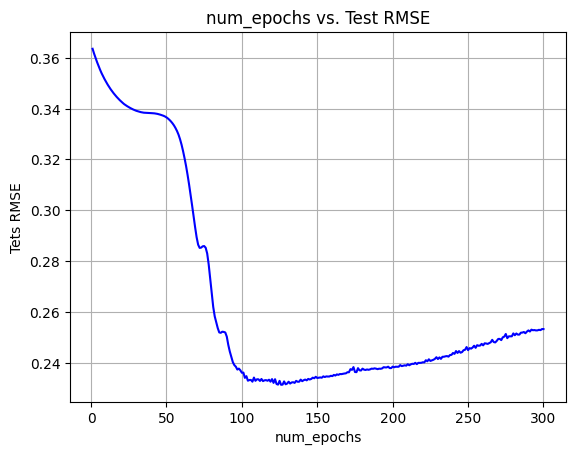

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.2313020158721768
Corresponding R^2 SCore: 0.5067090666334924
Corresponding num_epochs: 126


#### Test R^2 Score vs. num_epochs

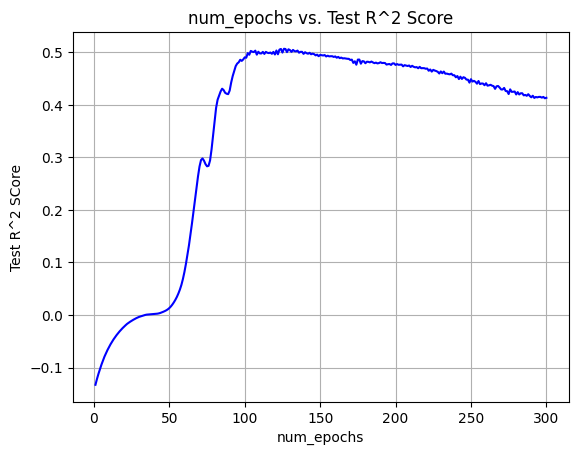

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5067090666334924
Corresponding RMSE: 0.2313020158721768
Corresponding num_epochs: 126


#### Test Adjsuted R^2 Score (Valence) vs. num_epochs

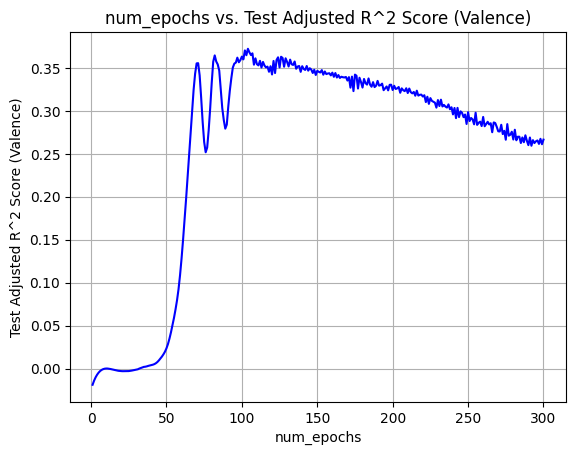

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.3720297325121601
Corresponding RMSE: 0.2329043355494024
Corresponding num_epochs: 104


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

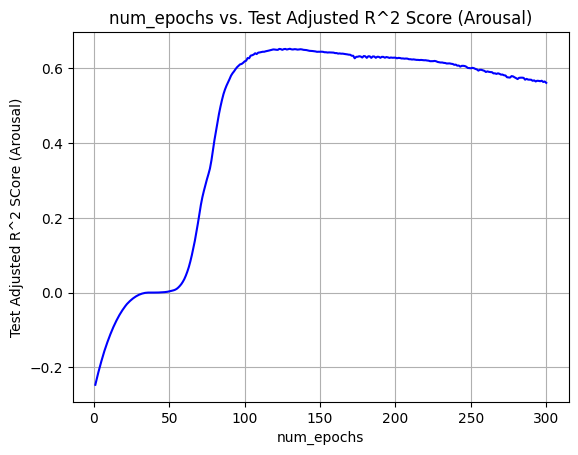

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.6515897514027089
Corresponding RMSE: 0.23177721399443038
Corresponding num_epochs: 130
